In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random

import h5py

In [2]:
%matplotlib notebook

In [3]:
import sys
sys.path.append('../../../../nadavp/new_trap/Tools/')
sys.path.append('../../../../nadavp/new_trap/Tools/StatFramework/')
import BeadDataFile
from discharge_tools import *

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
from likelihood_calculator import likelihood_analyser
from likelihood_calculator import GravityFramework
from likelihood_calculator import auxiliary_functions as aux
gfw = GravityFramework.GravityFramework()

In [6]:
gfw = GravityFramework.GravityFramework()

### Load data

In [7]:
bdf_discharge = load_dir(dirname='/data/new_trap/20200226/Bead1/Discharge/')

91  files in folder
91  files loaded


In [9]:
dis_z = [np.std(bb.response_at_freq2('z', drive_freq=71)) for bb in  bdf_discharge]
dis_x = [np.std(bb.response_at_freq2('x', drive_freq=71)) for bb in  bdf_discharge]

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [10]:
bdf_z = bdf_discharge[44:48]
bdf_x = bdf_discharge[48:53]
m1s_z = gfw.build_z_response(bdf_z, drive_freq=71,charges=13, bandwidth=2, decimate=100, include_sigma=False)
m1s_x = gfw.build_x_response(bdf_x, drive_freq=71,charges=13, bandwidth=2, decimate=100)

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


***************************************************
Z2-amplitude:  3.78e+03
reduced chi2:  4508.738370786036
***************************************************
Z2-amplitude:  3.87e+03
reduced chi2:  6199.230566294556
***************************************************
Z2-amplitude:  3.83e+03
reduced chi2:  6457.660291667214
***************************************************
Z2-amplitude:  3.93e+03
reduced chi2:  7219.321151755275
Z2 response (amplitude): 3854.1137226501196
***************************************************
X2-amplitude:  5.77e+01
reduced chi2:  1.2343547115776499
***************************************************
X2-amplitude:  5.84e+01
reduced chi2:  0.7482376251828428
***************************************************
X2-amplitude:  5.81e+01
reduced chi2:  1.14425487524474
***************************************************
X2-amplitude:  5.72e+01
reduced chi2:  0.7531713577272863
***************************************************
X2-amplitude:  5.77e+01
reduce

### Transfer function

In [11]:
fname = r'/data/new_trap/20200210/Bead2/TransFunc/TransFunc_X_3.h5'
tf_x = BeadDataFile.BeadDataFile(fname=fname)
fname = r'/data/new_trap/20200210/Bead2/TransFunc/TransFunc_Y_3.h5'
tf_y = BeadDataFile.BeadDataFile(fname=fname)
fname = r'/data/new_trap/20200210/Bead2/TransFunc/TransFunc_Z_3.h5'
tf_z = BeadDataFile.BeadDataFile(fname=fname)
tf_list = [tf_x, tf_y, tf_z]

No height data
No cantilever data
Error loading spinning data
No height data
No cantilever data
Error loading spinning data
No height data
No cantilever data
Error loading spinning data


<IPython.core.display.Javascript object>


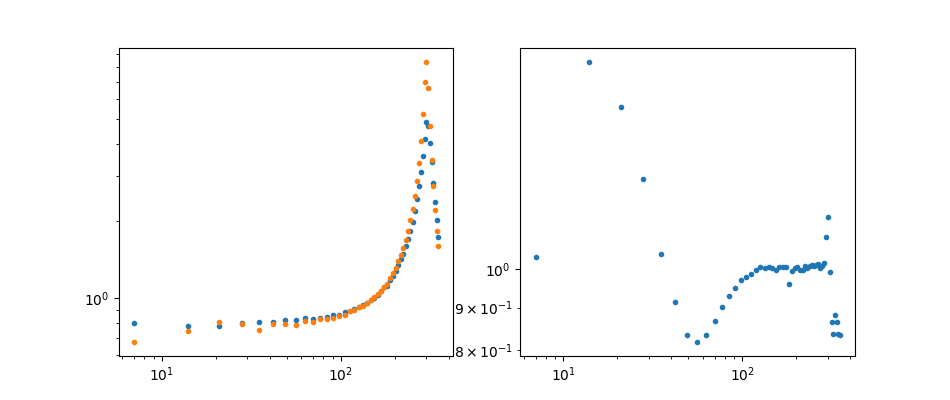

In [12]:
gfw.build_transfer_function(tf_list, plot=True)

In [59]:
# Normal feedback values
foldername = r'/data/new_trap/20200226/Bead1/Shaking/Shaking385/'
datasets_num = 1000
data_bdfs = load_dir(foldername, file_prefix='Shaking2', start_file=4000, max_file=datasets_num)

5000  files in folder
1000  files loaded


In [60]:
gfw.BDFs = data_bdfs

<IPython.core.display.Javascript object>


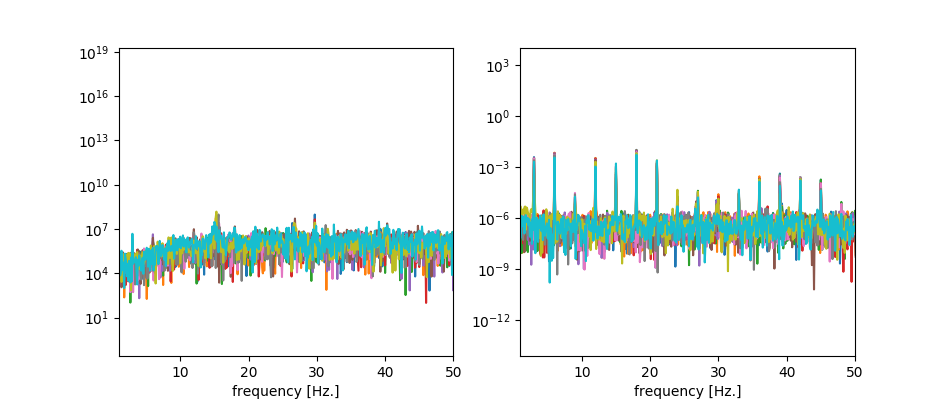

[(1, 50), Text(0.5, 0, 'frequency [Hz.]')]

In [61]:
_,ax = plt.subplots(1,2,figsize=(9.5,4),sharex=True)
for i,bb in enumerate(data_bdfs[::100]):
    ax[0].semilogy(*bb.psd2('z'))
ax[0].set(xlim=(1,50),xlabel='frequency [Hz.]')

for i,bb in enumerate(data_bdfs[::100]):
    ax[1].semilogy(*bb.psd2('x'))
ax[1].set(xlim=(1,50),xlabel='frequency [Hz.]')

In [51]:
gfw.build_noise_array(sideband_freq=20, bandwidth=2)
gfw.build_noise_array_z(sideband_freq=20, bandwidth=2)

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


x2 noise rms:  4.6532290335005895
x3 noise rms:  2.0264330043643404
z2 noise level:  20.563691469741233  std:  3.935285010649391


### profile likelihood fit

In [62]:
fit_kwargs2 = {'alpha': 0, 'phase': 0, 'sigma': 17, 'error_alpha': 0.01, 'error_phase': 1, 'error_sigma': 1,
              'errordef': 1,
              'limit_alpha': [-100, 100], 'limit_phase': [-5,5], 'limit_sigma': [0,None],
              'fix_alpha': False, 'fix_phase': False, 'fix_sigma': False, 'print_level': 0}

min_18_z_5 = []
min_20_z_5 = []
datasets_num = 1000
bandwidth = 2
center_freq = 18
for i,bb in enumerate(gfw.BDFs):
    print(i,'/',datasets_num) 
    min_18_z_5.append(gfw.get_alpha_mle_pl(bdf=bb, center_freq=center_freq, noise_freq=center_freq+bandwidth, 
                                             bandwidth=bandwidth, decimate=100, direction1='z',
                          x_focous=394.5, frequency=3, lambda_par=0.0001, height=6e-6, suppress_print=False,
                          **fit_kwargs2)[2])
    min_20_z_5.append(gfw.get_alpha_mle_pl(bdf=bb, center_freq=20, noise_freq=22, 
                                         bandwidth=bandwidth, decimate=100, direction1='z',
                      x_focous=394.5, frequency=5, lambda_par=0.0001, height=6e-6, suppress_print=False,
                      **fit_kwargs2)[2])

0 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  7.82e-03
sigma mle:  2.08e+01
reduced chi2:  0.11311689631553973
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  6.16e-03
sigma mle:  1.96e+01
reduced chi2:  0.11114623932215711
1 / 1000
Separation (face to face):  6.5
St

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


***************************************************
alpha mle:  7.48e-03
sigma mle:  1.74e+01
reduced chi2:  0.10749787838779751
3 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.51e-02
sigma mle:  2.04e+01
reduced chi2:  0.11253172721761744
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*******************************************

***************************************************
alpha mle:  7.35e-03
sigma mle:  2.08e+01
reduced chi2:  0.11295427710348199
12 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  3.92e-03
sigma mle:  1.97e+01
reduced chi2:  0.11144629186803205
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  -6.00e-03
sigma mle:  2.37e+01
reduced chi2:  0.11727658882215751
23 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  3.97e-03
sigma mle:  1.93e+01
reduced chi2:  0.11043795226807625
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -9.09e-03
sigma mle:  2.10e+01
reduced chi2:  0.1134107607829326
32 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  8.90e-03
sigma mle:  2.13e+01
reduced chi2:  0.11391723527453985
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  -1.03e-02
sigma mle:  2.05e+01
reduced chi2:  0.11260389417077313
41 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.08e-02
sigma mle:  1.90e+01
reduced chi2:  0.11019383304785886
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  1.15e-03
sigma mle:  2.15e+01
reduced chi2:  0.11413976643996912
52 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.33e-02
sigma mle:  2.01e+01
reduced chi2:  0.11205881523723056
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  4.35e-03
sigma mle:  2.01e+01
reduced chi2:  0.11206001330492313
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  8.46e-03
sigma mle:  2.01e+01
reduced chi2:  0.11206644381983374
63 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  -7.12e-03
sigma mle:  2.01e+01
reduced chi2:  0.11196174603887579
73 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.06e-02
sigma mle:  2.19e+01
reduced chi2:  0.11483934468662935
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  1.45e-02
sigma mle:  2.23e+01
reduced chi2:  0.11533477553652613
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  2.89e-03
sigma mle:  2.14e+01
reduced chi2:  0.11409169672866148
83 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  2.46e-03
sigma mle:  2.27e+01
reduced chi2:  0.11589100333479872
93 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  4.23e-03
sigma mle:  1.93e+01
reduced chi2:  0.11077739985169682
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  -3.95e-03
sigma mle:  2.56e+01
reduced chi2:  0.11974017386282583
102 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -3.68e-03
sigma mle:  2.23e+01
reduced chi2:  0.11530463132638291
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  5.36e-03
sigma mle:  2.43e+01
reduced chi2:  0.11858768226243384
111 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.06e-02
sigma mle:  1.96e+01
reduced chi2:  0.11115458041987492
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -1.75e-02
sigma mle:  2.21e+01
reduced chi2:  0.11529471447113172
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.08e-02
sigma mle:  2.01e+01
reduced chi2:  0.1120747306094032
121 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -1.29e-02
sigma mle:  2.26e+01
reduced chi2:  0.11580421092270177
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -6.90e-03
sigma mle:  2.28e+01
reduced chi2:  0.11612114983185105
130 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -1.30e-02
sigma mle:  2.05e+01
reduced chi2:  0.1125934966148192
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -2.92e-03
sigma mle:  2.47e+01
reduced chi2:  0.11865960733933537
139 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -6.04e-03
sigma mle:  3.56e+01
reduced chi2:  0.1302879388753042
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.46e-02
sigma mle:  3.96e+01
reduced chi2:  0.1337543060606209
149 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  1.52e-02
sigma mle:  3.06e+01
reduced chi2:  0.1254670771423105
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -5.19e-03
sigma mle:  3.25e+01
reduced chi2:  0.12742604054404089
159 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  8.64e-03
sigma mle:  2.14e+01
reduced chi2:  0.1140534820508852
168 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  4.60e-03
sigma mle:  2.11e+01
reduced chi2:  0.11356189713988614
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  -4.75e-03
sigma mle:  1.99e+01
reduced chi2:  0.11172424003853643
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -4.30e-03
sigma mle:  2.20e+01
reduced chi2:  0.11495108170581123
178 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -8.86e-03
sigma mle:  2.25e+01
reduced chi2:  0.11560779372733966
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  4.35e-03
sigma mle:  2.34e+01
reduced chi2:  0.1168565556978738
187 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.80e-02
sigma mle:  2.92e+01
reduced chi2:  0.12401165027244906
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  8.28e-03
sigma mle:  2.82e+01
reduced chi2:  0.12292535748042603
196 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Ta

***************************************************
alpha mle:  1.07e-02
sigma mle:  2.64e+01
reduced chi2:  0.12300976029708267
205 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.45e-02
sigma mle:  2.25e+01
reduced chi2:  0.11566167739756701
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  5.19e-03
sigma mle:  2.09e+01
reduced chi2:  0.11325855796960366
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -8.46e-03
sigma mle:  2.47e+01
reduced chi2:  0.11858795204613365
215 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -1.98e-03
sigma mle:  2.34e+01
reduced chi2:  0.11688750282256115
224 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -9.46e-03
sigma mle:  2.26e+01
reduced chi2:  0.11570782182173452
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -4.38e-03
sigma mle:  2.17e+01
reduced chi2:  0.11454645493850646
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -5.07e-03
sigma mle:  2.08e+01
reduced chi2:  0.11307179250085451
235 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  5.50e-03
sigma mle:  2.07e+01
reduced chi2:  0.11295999288333385
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -3.16e-03
sigma mle:  1.87e+01
reduced chi2:  0.10966724140940654
244 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -6.79e-03
sigma mle:  2.17e+01
reduced chi2:  0.11451926671143395
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -9.15e-03
sigma mle:  2.30e+01
reduced chi2:  0.1164065088165837
254 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -5.75e-03
sigma mle:  2.58e+01
reduced chi2:  0.12001492421569251
263 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -6.44e-03
sigma mle:  2.72e+01
reduced chi2:  0.12165436579874521
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -1.74e-02
sigma mle:  2.25e+01
reduced chi2:  0.11573245725061178
272 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.32e-03
sigma mle:  2.23e+01
reduced chi2:  0.11527750110467685
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -2.28e-03
sigma mle:  2.79e+01
reduced chi2:  0.1225502500428677
282 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  7.00e-04
sigma mle:  2.17e+01
reduced chi2:  0.11454367674495822
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -8.83e-03
sigma mle:  2.00e+01
reduced chi2:  0.11180057439288714
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  6.40e-03
sigma mle:  2.12e+01
reduced chi2:  0.11377909759594168
293 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -9.18e-03
sigma mle:  2.51e+01
reduced chi2:  0.11906643408932527
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -5.46e-03
sigma mle:  2.66e+01
reduced chi2:  0.12102095027467293
303 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  5.16e-03
sigma mle:  2.37e+01
reduced chi2:  0.11729621517285327
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  9.51e-03
sigma mle:  2.37e+01
reduced chi2:  0.11735714041249291
313 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Tak

***************************************************
alpha mle:  -8.47e-03
sigma mle:  2.25e+01
reduced chi2:  0.11569180563022745
323 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  8.84e-03
sigma mle:  1.99e+01
reduced chi2:  0.11165931994106404
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  7.58e-03
sigma mle:  2.46e+01
reduced chi2:  0.11845465637679907
333 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.39e-03
sigma mle:  1.99e+01
reduced chi2:  0.11118926709311558
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Ta

***************************************************
alpha mle:  -1.07e-02
sigma mle:  2.11e+01
reduced chi2:  0.11362672986965076
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -8.85e-03
sigma mle:  2.54e+01
reduced chi2:  0.11949662695850556
343 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -1.22e-02
sigma mle:  2.02e+01
reduced chi2:  0.11223228290043498
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  9.43e-04
sigma mle:  2.24e+01
reduced chi2:  0.1154763071747393
354 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.12e-02
sigma mle:  2.16e+01
reduced chi2:  0.11435645870329454
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  3.20e-03
sigma mle:  2.44e+01
reduced chi2:  0.11828352686885746
363 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of l

***************************************************
alpha mle:  -1.02e-02
sigma mle:  2.80e+01
reduced chi2:  0.12266994750347739
372 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -7.38e-03
sigma mle:  2.72e+01
reduced chi2:  0.12165881687488739
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

reduced chi2:  0.12220036611848521
382 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.24e-02
sigma mle:  2.51e+01
reduced chi2:  0.11907892988785641
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  4.79e-03
sigma mle:  2.51e+01
reduced chi2:  0.1191205535314236
383 / 

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  9.06e-03
sigma mle:  4.61e+01
reduced chi2:  0.1385926390713573
393 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.85e-02
sigma mle:  4.72e+01
reduced chi2:  0.13932978066192497
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Tak

***************************************************
alpha mle:  3.62e-03
sigma mle:  2.76e+01
reduced chi2:  0.12219389117469578
402 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -2.19e-02
sigma mle:  2.87e+01
reduced chi2:  0.1233805924129496
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -5.99e-03
sigma mle:  2.45e+01
reduced chi2:  0.11831622479411182
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  6.11e-03
sigma mle:  2.64e+01
reduced chi2:  0.12069168020528369
413 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  1.01e-02
sigma mle:  3.14e+01
reduced chi2:  0.12624851433415996
422 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -2.30e-02
sigma mle:  2.95e+01
reduced chi2:  0.1242987513346013
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

reduced chi2:  0.11657929423420613
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -8.23e-03
sigma mle:  2.39e+01
reduced chi2:  0.11755493810382502
433 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.35e-02
sigma mle:  2.67e+01
reduced chi2:  0.12114362019295377
Sepa

***************************************************
alpha mle:  6.13e-03
sigma mle:  2.83e+01
reduced chi2:  0.12292664964151978
443 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.40e-02
sigma mle:  2.15e+01
reduced chi2:  0.11416563243459471
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -2.71e-02
sigma mle:  4.43e+01
reduced chi2:  0.13731880169506921
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.59e-02
sigma mle:  4.09e+01
reduced chi2:  0.1347172153719103
454 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  4.75e-02
sigma mle:  5.13e+01
reduced chi2:  0.14202521954628297
464 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -7.29e-03
sigma mle:  4.34e+01
reduced chi2:  0.13663695508713336
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -2.47e-02
sigma mle:  3.12e+01
reduced chi2:  0.12605801353054297
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  2.00e-03
sigma mle:  2.86e+01
reduced chi2:  0.12332701377481804
475 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -3.11e-02
sigma mle:  3.98e+01
reduced chi2:  0.13389020000520796
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.32e-02
sigma mle:  3.75e+01
reduced chi2:  0.13196431363721928
485 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -1.44e-02
sigma mle:  3.21e+01
reduced chi2:  0.1269848322879946
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -5.79e-03
sigma mle:  3.77e+01
reduced chi2:  0.1321694805442481
495 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -2.34e-02
sigma mle:  2.93e+01
reduced chi2:  0.12409813644732393
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  9.27e-03
sigma mle:  2.93e+01
reduced chi2:  0.1240398220738889
505 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -3.33e-03
sigma mle:  2.91e+01
reduced chi2:  0.12385910470931583
515 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.89e-02
sigma mle:  2.65e+01
reduced chi2:  0.12089892291297849
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -6.58e-03
sigma mle:  2.28e+01
reduced chi2:  0.11601433916911714
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -9.91e-03
sigma mle:  2.46e+01
reduced chi2:  0.12020562743833955
525 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.77e-03
sigma mle:  2.39e+01
reduced chi2:  0.11750374840970228
536 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -6.79e-03
sigma mle:  2.72e+01
reduced chi2:  0.12118351731385268
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
T

***************************************************
alpha mle:  -7.11e-03
sigma mle:  3.37e+01
reduced chi2:  0.128571419971384
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.69e-02
sigma mle:  3.22e+01
reduced chi2:  0.12711987070110217
547 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  2.88e-02
sigma mle:  4.50e+01
reduced chi2:  0.13780247735497808
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.11e-02
sigma mle:  4.04e+01
reduced chi2:  0.1343793304308483
557 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taki

***************************************************
alpha mle:  1.92e-02
sigma mle:  3.23e+01
reduced chi2:  0.12716887010385963
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.74e-03
sigma mle:  3.39e+01
reduced chi2:  0.12872813120564966
566 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.10e-03
sigma mle:  2.23e+01
reduced chi2:  0.11534726327165096
577 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  9.44e-03
sigma mle:  1.96e+01
reduced chi2:  0.11121354048959521
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selec

***************************************************
alpha mle:  -3.19e-03
sigma mle:  2.61e+01
reduced chi2:  0.12041291046413456
587 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  6.06e-04
sigma mle:  2.29e+01
reduced chi2:  0.11621494641675556
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -9.68e-03
sigma mle:  2.53e+01
reduced chi2:  0.11940366932864865
597 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.01e-02
sigma mle:  2.39e+01
reduced chi2:  0.11750194287758992
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  4.37e-03
sigma mle:  2.63e+01
reduced chi2:  0.12066293478854853
607 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.37e-02
sigma mle:  2.45e+01
reduced chi2:  0.11831270039981219
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -2.10e-02
sigma mle:  2.22e+01
reduced chi2:  0.11516480653163366
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  2.67e-03
sigma mle:  2.44e+01
reduced chi2:  0.11817586110239446
618 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Ta

***************************************************
alpha mle:  -1.13e-02
sigma mle:  2.81e+01
reduced chi2:  0.1227304062072282
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.00e-02
sigma mle:  2.63e+01
reduced chi2:  0.12059225862193389
627 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -6.70e-03
sigma mle:  2.39e+01
reduced chi2:  0.11757655309073782
636 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.05e-02
sigma mle:  2.30e+01
reduced chi2:  0.11627007302767937
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
T

***************************************************
alpha mle:  7.15e-03
sigma mle:  2.93e+01
reduced chi2:  0.12403431032612992
645 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -8.41e-03
sigma mle:  2.55e+01
reduced chi2:  0.11964343553891733
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  3.72e-03
sigma mle:  2.36e+01
reduced chi2:  0.11714693826147295
655 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.35e-02
sigma mle:  2.28e+01
reduced chi2:  0.11602520456590601
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  6.92e-03
sigma mle:  2.71e+01
reduced chi2:  0.12163306928128279
665 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.43e-02
sigma mle:  2.82e+01
reduced chi2:  0.12289120373433635
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  2.40e-03
sigma mle:  3.56e+01
reduced chi2:  0.13034839618580227
675 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  3.14e-02
sigma mle:  3.63e+01
reduced chi2:  0.1309076387931474
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

684 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -9.70e-03
sigma mle:  2.40e+01
reduced chi2:  0.11765552129827322
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  5.60e-03
sigma mle:  2.37e+01
reduced chi2:  0.11732495690531071
685 / 1000
Separation (face to face):  6

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  8.83e-03
sigma mle:  2.38e+01
reduced chi2:  0.11736468752831695
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  2.00e-03
sigma mle:  2.29e+01
reduced chi2:  0.11624919049718095
695 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Tak

***************************************************
alpha mle:  -8.10e-03
sigma mle:  2.20e+01
reduced chi2:  0.11486574956504879
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.43e-02
sigma mle:  2.44e+01
reduced chi2:  0.1204626781799642
704 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  1.15e-02
sigma mle:  2.61e+01
reduced chi2:  0.12033449006455833
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  5.22e-03
sigma mle:  2.85e+01
reduced chi2:  0.12315694321350189
715 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -1.02e-02
sigma mle:  2.42e+01
reduced chi2:  0.1179572773137415
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  4.91e-03
sigma mle:  2.59e+01
reduced chi2:  0.12008363995059265
725 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  3.82e-03
sigma mle:  2.47e+01
reduced chi2:  0.11866416253291615
735 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  5.06e-03
sigma mle:  2.09e+01
reduced chi2:  0.11328123718312436
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  2.20e-02
sigma mle:  2.59e+01
reduced chi2:  0.12032756544980225
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.02e-02
sigma mle:  2.88e+01
reduced chi2:  0.1255289790470475
746 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  -7.18e-03
sigma mle:  2.59e+01
reduced chi2:  0.12019293407182403
756 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.39e-02
sigma mle:  2.82e+01
reduced chi2:  0.12291049523126484
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  4.28e-02
sigma mle:  5.40e+01
reduced chi2:  0.14117628876944802
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.55e-02
sigma mle:  5.03e+01
reduced chi2:  0.141373692638864
766 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*******************************************

***************************************************
alpha mle:  1.18e-02
sigma mle:  4.08e+01
reduced chi2:  0.1347094727054713
776 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -6.77e-03
sigma mle:  3.11e+01
reduced chi2:  0.12599832218313983
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -2.39e-03
sigma mle:  3.00e+01
reduced chi2:  0.12485652471105971
786 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.69e-02
sigma mle:  2.47e+01
reduced chi2:  0.11861174686458364
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -1.50e-02
sigma mle:  3.40e+01
reduced chi2:  0.12886060248888256
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.03e-02
sigma mle:  3.27e+01
reduced chi2:  0.12760152946198103
797 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -2.15e-02
sigma mle:  2.91e+01
reduced chi2:  0.12392555115063834
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -4.31e-03
sigma mle:  3.24e+01
reduced chi2:  0.12728757475131638
807 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  2.91e-02
sigma mle:  2.97e+01
reduced chi2:  0.12456870062477428
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.27e-02
sigma mle:  2.91e+01
reduced chi2:  0.1255076001647605
817 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -1.27e-02
sigma mle:  3.26e+01
reduced chi2:  0.12746994356468874
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  3.39e-04
sigma mle:  3.57e+01
reduced chi2:  0.13040732026150995
826 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  1.24e-02
sigma mle:  2.87e+01
reduced chi2:  0.12339995790118002
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  4.41e-03
sigma mle:  2.53e+01
reduced chi2:  0.11943721283977692
836 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -2.28e-02
sigma mle:  3.62e+01
reduced chi2:  0.13082144412183527
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  6.09e-03
sigma mle:  3.34e+01
reduced chi2:  0.12829323046882393
845 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  1.42e-02
sigma mle:  3.91e+01
reduced chi2:  0.13330664976535073
855 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.92e-02
sigma mle:  4.47e+01
reduced chi2:  0.1375699649753569
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

***************************************************
alpha mle:  3.15e-02
sigma mle:  4.48e+01
reduced chi2:  0.1376836368618609
865 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  3.33e-02
sigma mle:  4.20e+01
reduced chi2:  0.13561821369705396
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
******************************************

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  5.08e-03
sigma mle:  2.16e+01
reduced chi2:  0.11427209846759458
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  8.21e-03
sigma mle:  2.51e+01
reduced chi2:  0.11918449931906593
876 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Tak

***************************************************
alpha mle:  -1.94e-02
sigma mle:  2.83e+01
reduced chi2:  0.12299748768408915
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  4.37e-03
sigma mle:  2.70e+01
reduced chi2:  0.1219174670388721
886 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -1.11e-02
sigma mle:  5.09e+01
reduced chi2:  0.14173515796775712
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -8.74e-03
sigma mle:  4.85e+01
reduced chi2:  0.14018147801973277
896 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************

***************************************************
alpha mle:  -2.38e-02
sigma mle:  3.65e+01
reduced chi2:  0.1311191154382411
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.65e-02
sigma mle:  3.85e+01
reduced chi2:  0.13282758074029352
906 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  9.48e-03
sigma mle:  3.74e+01
reduced chi2:  0.1318926846226489
915 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -3.00e-02
sigma mle:  4.09e+01
reduced chi2:  0.13477895830117756
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

***************************************************
alpha mle:  -2.17e-02
sigma mle:  3.30e+01
reduced chi2:  0.12790652158472135
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.07e-02
sigma mle:  3.14e+01
reduced chi2:  0.1262635691573139
926 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -2.94e-02
sigma mle:  4.34e+01
reduced chi2:  0.13667042616645614
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  7.02e-03
sigma mle:  4.26e+01
reduced chi2:  0.13604183946886664
936 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -1.75e-02
sigma mle:  4.15e+01
reduced chi2:  0.13522190783393376
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  1.36e-03
sigma mle:  4.62e+01
reduced chi2:  0.13865795787915258
946 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  6.09e-03
sigma mle:  4.00e+01
reduced chi2:  0.13407938952593224
956 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  2.55e-02
sigma mle:  3.83e+01
reduced chi2:  0.13262927769847274
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
*****************************************

Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.85e-02
sigma mle:  2.86e+01
reduced chi2:  0.12327682328021074
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  3.98e-03
sigma mle:  3.02e+01
reduced chi2:  0.1248661116700052
967 / 1000
Separation (face to face):  6.5
Stroke:  

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -1.54e-02
sigma mle:  4.39e+01
reduced chi2:  0.13699465374107922
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  -2.33e-02
sigma mle:  3.95e+01
reduced chi2:  0.13365851250459618
977 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
T

***************************************************
alpha mle:  -1.44e-02
sigma mle:  2.64e+01
reduced chi2:  0.12080232658599332
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  5.31e-03
sigma mle:  2.87e+01
reduced chi2:  0.12344945974864265
986 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

***************************************************
alpha mle:  -1.37e-02
sigma mle:  2.88e+01
reduced chi2:  0.12354965839005344
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
***************************************************
alpha mle:  4.86e-03
sigma mle:  2.74e+01
reduced chi2:  0.12195689275981964
996 / 1000
Separation (face to face):  6.5
Stroke:  100
Time:  10.0
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 2.40e-06 is selected
2.4e-06
2.4e-06
A bead size of 2.40e-06 is selected
2.4e-06
posvec
A bead size of 2.40e-06 is selected
2.4e-06
A separation of 6.50e-06 is selected
A height of 6.00e-06 is selected
****************************************

In [64]:
m_18_alpha_1 = [m1_.values[0] for m1_ in min_18_z]
m_18_sigma_1 = [m1_.values[2] for m1_ in min_18_z]

m_18_alpha_2 = [m1_.values[0] for m1_ in min_18_z_2]
m_18_sigma_2 = [m1_.values[2] for m1_ in min_18_z_2]

m_18_alpha_3 = [m1_.values[0] for m1_ in min_18_z_3]
m_18_sigma_3 = [m1_.values[2] for m1_ in min_18_z_3]

m_18_alpha_4 = [m1_.values[0] for m1_ in min_18_z_4]
m_18_sigma_4 = [m1_.values[2] for m1_ in min_18_z_4]

m_18_alpha_5 = [m1_.values[0] for m1_ in min_18_z_5]
m_18_sigma_5 = [m1_.values[2] for m1_ in min_18_z_5]

m_20_alpha_1 = [m1_.values[0] for m1_ in min_20_z]
m_20_sigma_1 = [m1_.values[2] for m1_ in min_20_z]

m_20_alpha_2 = [m1_.values[0] for m1_ in min_20_z_2]
m_20_sigma_2 = [m1_.values[2] for m1_ in min_20_z_2]

m_20_alpha_3 = [m1_.values[0] for m1_ in min_20_z_3]
m_20_sigma_3 = [m1_.values[2] for m1_ in min_20_z_3]

m_20_alpha_4 = [m1_.values[0] for m1_ in min_20_z_4]
m_20_sigma_4 = [m1_.values[2] for m1_ in min_20_z_4]

m_20_alpha_5 = [m1_.values[0] for m1_ in min_20_z_5]
m_20_sigma_5 = [m1_.values[2] for m1_ in min_20_z_5]

m_18_alpha = m_18_alpha_1+m_18_alpha_2+m_18_alpha_3+m_18_alpha_4+m_18_alpha_5
m_20_alpha = m_20_alpha_1+m_20_alpha_2+m_20_alpha_3+m_20_alpha_4+m_20_alpha_5
m_18_sigma = m_18_sigma_1+m_18_sigma_2+m_18_sigma_3+m_18_sigma_4+m_18_sigma_5

In [65]:
len(m_18_alpha)

5000

<IPython.core.display.Javascript object>


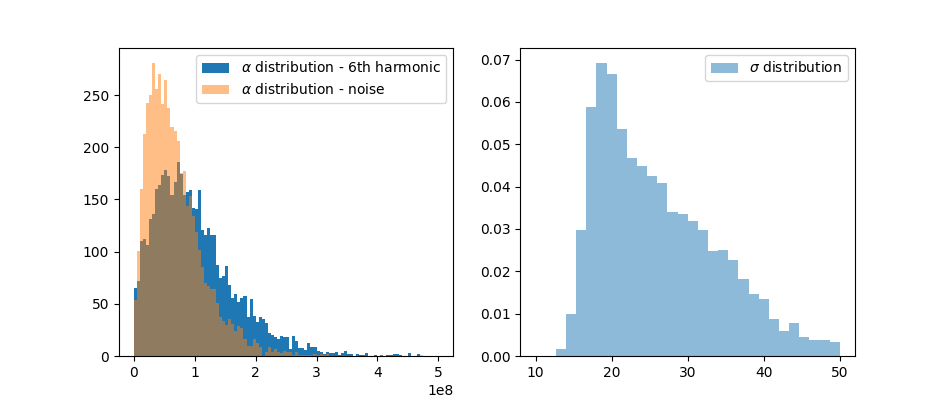

6th hsrmonic mean:  0.010216488766766951  error:  0.00011250842873402146
noise mean:  0.006841387203883272  error:  6.64898548723853e-05
estimated limit:  1.02e+08


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


In [78]:
_, ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].hist(np.array(np.abs(m_18_alpha))*1e10, range=(0,0.05*1e10), bins=100, label=r'$\alpha$ distribution - 6th harmonic')
ax[0].hist(np.array(np.abs(m_20_alpha))*1e10, range=(0,0.05*1e10), bins=100, alpha=0.5, label=r'$\alpha$ distribution - noise')
ax[1].hist(m_18_sigma,range=(10,50),bins=30,alpha=0.5,normed=True, label=r'$\sigma$ distribution')
[a.legend() for a in ax]
N_data = len(m_18_alpha)
print('6th hsrmonic mean: ',np.mean(np.abs(m_18_alpha)), ' error: ', np.std(np.abs(m_18_alpha))/np.sqrt(N_data))
print('noise mean: ',np.mean(np.abs(m_20_alpha)), ' error: ', np.std(np.abs(m_20_alpha))/np.sqrt(N_data))
print('estimated limit: ', format(np.mean(np.abs(m_18_alpha))*1e10,"5.2e"))

<IPython.core.display.Javascript object>


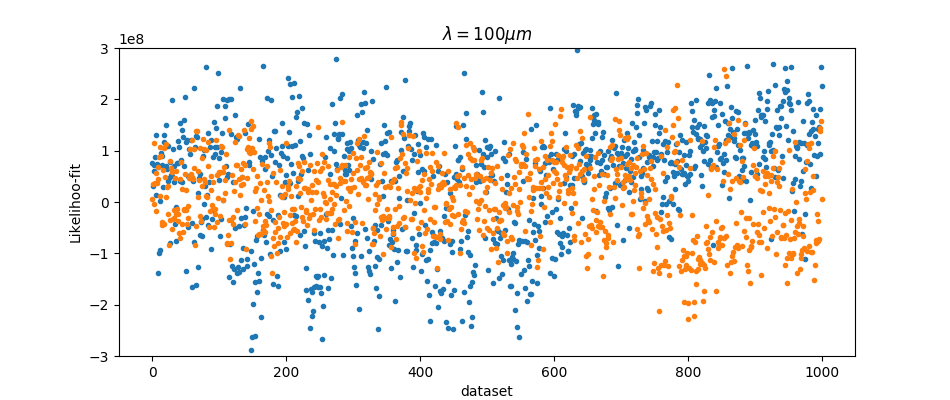

[(-300000000.0, 300000000.0)]

In [57]:
_, ax = plt.subplots(figsize=(9.5,4))
ax.plot(range(len(m_18_alpha_1)),np.array(m_18_alpha_1)*1e10,'.')
# ax.plot(range(len(m_18_alpha_2)),np.array(m_18_alpha_2)*1e10,'.')
# ax.plot(range(len(m_18_alpha_3)),np.array(m_18_alpha_3)*1e10,'.')
ax.plot(range(len(m_18_alpha_3)),np.array(m_18_alpha_4)*1e10,'.')
# ax.plot(range(len(m_18_alpha_3)),np.array(m_18_alpha_5)*1e10,'.')
# ax.plot(range(len(m_20_alpha)),np.array(m_20_alpha)*1e10,'.')
ax.set(xlabel='dataset', ylabel=r'Likelihoo-fit', title=r'$\lambda=100 \mu m $')
ax.set(ylim=(-3e8,3e8))

<IPython.core.display.Javascript object>


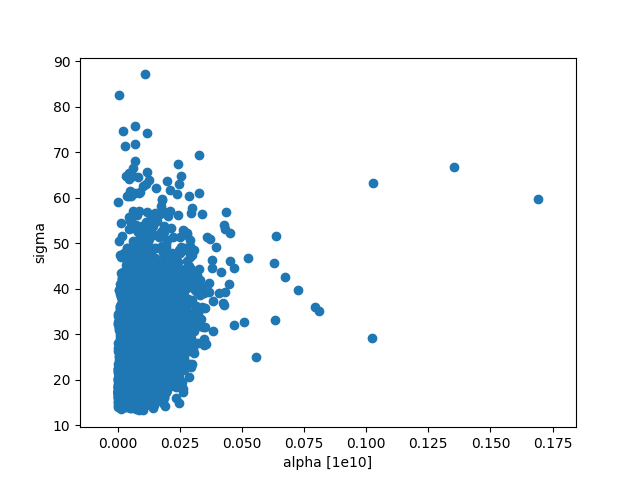

[Text(0, 0.5, 'sigma'), Text(0.5, 0, 'alpha [1e10]')]

In [106]:
_,ax = plt.subplots()
ax.scatter(np.abs(m_18_alpha), m_18_sigma)
ax.set(xlabel='alpha [1e10]', ylabel='sigma')
# sum(np.array(m_18_sigma_5)<50)/1000

In [67]:
x_pos_5  = [np.mean(bb.x2) for bb in data_bdfs]
y_pos_5  = [np.mean(bb.y2) for bb in data_bdfs]

<IPython.core.display.Javascript object>


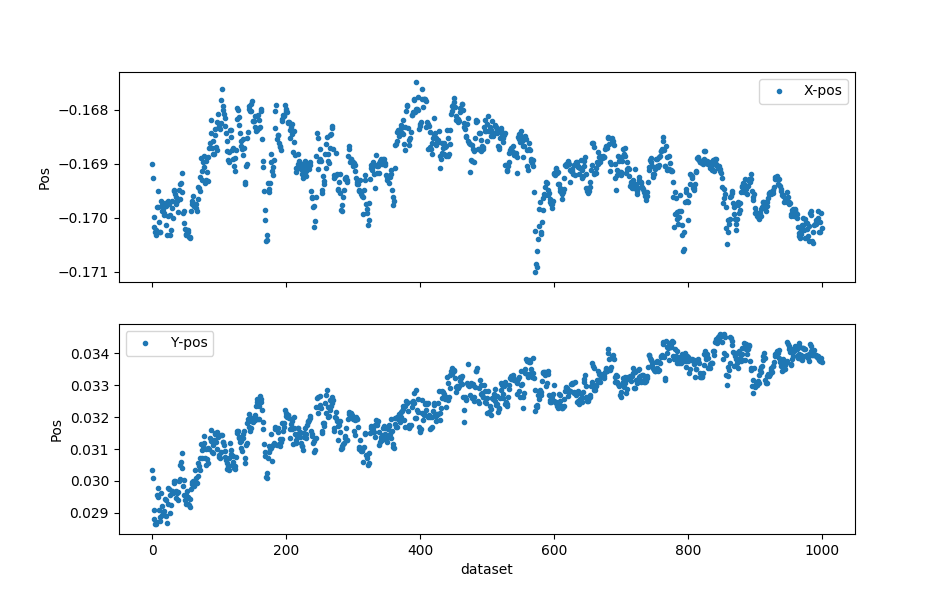

In [73]:
_, ax = plt.subplots(2,1,figsize=(9.5,6), sharex=True)
ax[0].plot(range(len(m_18_alpha_3)),np.array(x_pos_5),'.', label=r'X-pos')
ax[0].set(ylabel=r'Pos')
ax[0].legend()

ax[1].plot(range(len(m_18_alpha_3)),np.array(y_pos_5),'.', label=r'Y-pos')
ax[1].set(xlabel='dataset', ylabel=r'Pos')
ax[1].legend()

# [a.set(ylim=(-0.06,0.1)) for a in ax]

In [81]:
alpha_filtered = [alp for alp,sig in zip(m_18_alpha,m_18_sigma) if sig<20]
alpha_filtered_noise = [alp for alp,sig in zip(m_20_alpha,m_18_sigma) if sig<20]
len(alpha_filtered)

1308

<IPython.core.display.Javascript object>


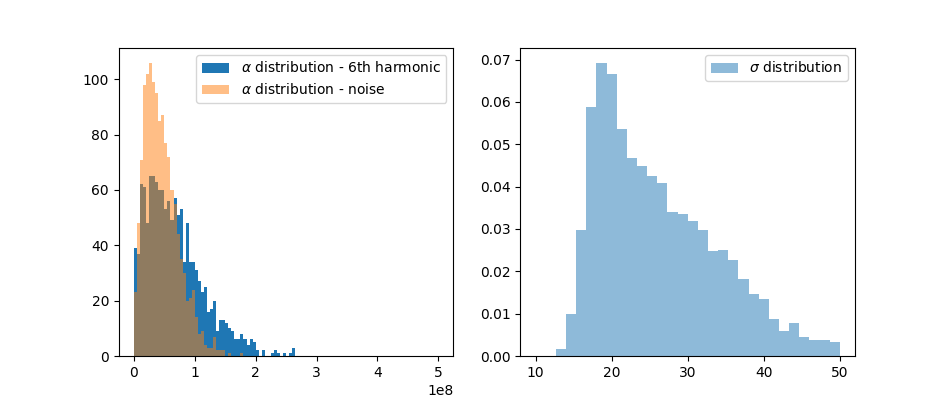

6th hsrmonic mean:  0.004213370946420791  error:  6.634832084232925e-05
noise mean:  0.004543618763529565  error:  3.922311561906823e-05
estimated limit:  4.54e+07


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


In [82]:
_, ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].hist(np.array(np.abs(alpha_filtered))*1e10, range=(0,0.05*1e10), bins=100, label=r'$\alpha$ distribution - 6th harmonic')
ax[0].hist(np.array(np.abs(alpha_filtered_noise))*1e10, range=(0,0.05*1e10), bins=100, alpha=0.5, label=r'$\alpha$ distribution - noise')
ax[1].hist(m_18_sigma,range=(10,50),bins=30,alpha=0.5,normed=True, label=r'$\sigma$ distribution')
[a.legend() for a in ax]
N_data = len(m_18_alpha)
print('6th hsrmonic mean: ',np.mean(alpha_filtered), ' error: ', np.std(np.abs(alpha_filtered))/np.sqrt(N_data))
print('noise mean: ',np.mean(np.abs(alpha_filtered_noise)), ' error: ', np.std(np.abs(alpha_filtered_noise))/np.sqrt(N_data))
print('estimated limit: ', format(np.mean(np.abs(alpha_filtered_noise))*1e10,"5.2e"))

In [94]:
i_filtered = [i for i,sig in enumerate(m_18_sigma) if ((sig<20)&(sig>19)) if i >4000]
i_filtered_noise = [i for i,sig in enumerate(m_18_sigma) if ((sig<40)&(sig>39)) if i > 4000]

<IPython.core.display.Javascript object>


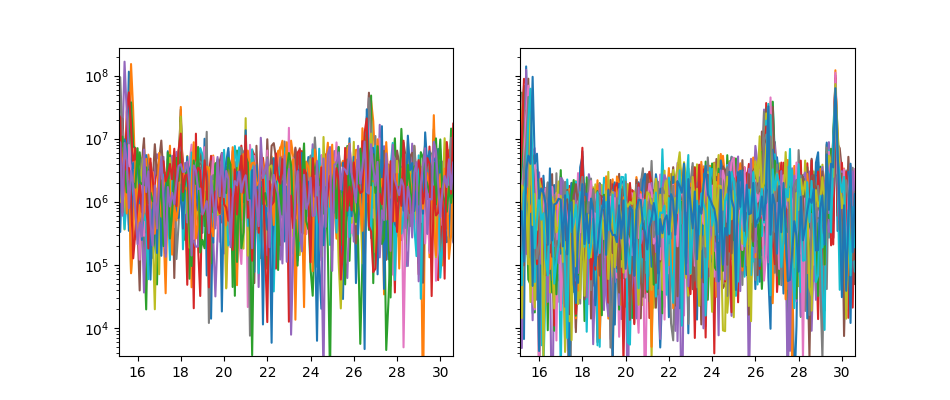

[(0, 50)]

In [104]:
_,ax = plt.subplots(1,2,figsize=(9.5,4), sharex=True, sharey=True)

for i in i_filtered_noise:
    bb = data_bdfs[i-4000]
    ax[0].semilogy(*bb.psd2('z'))
    
    
for i in i_filtered:
    bb = data_bdfs[i-4000]
    ax[1].semilogy(*bb.psd2('z'))
ax[0].set(xlim=(0,50))